In [1]:
import torch 
import os
import numpy as np
import random
import torch.nn as nn
from PacthEmbedding import *
from torch.utils.data import Dataset, DataLoader
from moco_framework import Moco_v3
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy.optimize import linear_sum_assignment
from sklearn.model_selection import train_test_split
import seaborn as sns
from torch.utils.data import random_split
import torch.optim as optim

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

#### Load and combine data


In [ ]:
def load_and_combine_data(data_folder, label_folder, max_files=None):
    data_files = sorted(os.listdir(data_folder))[:max_files]
    label_files = sorted(os.listdir(label_folder))[:max_files]

    combined_data = []
    combined_label = []

    for data_file, label_file in zip(data_files, label_files):
        data_path = os.path.join(data_folder, data_file)
        loaded_data = np.load(data_path)
        combined_data.append(loaded_data)

        label_path = os.path.join(label_folder, label_file)
        loaded_label = np.load(label_path)
        combined_label.append(loaded_label)

    combined_data = np.concatenate(combined_data, axis=0)
    combined_label = np.concatenate(combined_label, axis=0)

    return combined_data, combined_label

data_folder = './dataset/data/'
label_folder = '.dataset/label/'

test_data, test_label = load_and_combine_data(data_folder, label_folder, 3)

In [5]:
print(test_data.shape)
print(test_label.shape)

(3000, 32, 6, 32, 32)
(3000,)


In [6]:
def change_label(labels):
    labels = np.array(labels)
    labels[labels > 0] -= 1
    labels[labels > 2] -= 2
    
    return labels
test_label = change_label(test_label)

#### labels mapping

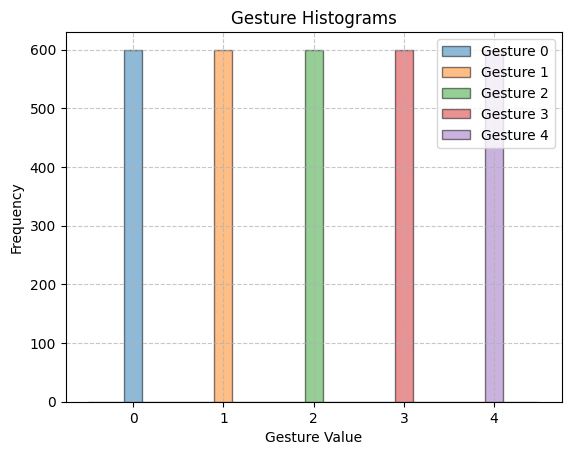

In [7]:
unique_gestures = np.unique(test_label)
plt.figure()

for gesture in unique_gestures:
    gesture_data = test_label[test_label == gesture]
    
    plt.hist(gesture_data, bins=len(unique_gestures), edgecolor='black', alpha=0.5, label=f'Gesture {gesture}')

plt.title('Gesture Histograms')
plt.xlabel('Gesture Value')
plt.ylabel('Frequency')
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

#### Dataset and Dataloader

In [ ]:
class MocoDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        item_label = self.label[idx]

        patch = torch.tensor(item, dtype=torch.float32)
        
        return patch, item_label
        

def Moco_data_loader(data, label, batch_size=64):
    dataset = MocoDataset(data, label)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return test_loader

#### Load model file

In [9]:
checkpoint = torch.load('checkpoints/normal.pth',map_location=torch.device('cpu'),weights_only=True)
feature_extractor = Moco_v3(embed_dim= 256, encoder_depth= 6, mask_ratio= 0.2, mlp_dim = 512)
feature_extractor.load_state_dict(checkpoint['model'])

test_loader = Moco_data_loader(test_data, test_label)

#### Extract features

In [10]:
def extract_features(feature_extractor, dataloader):
    feature_extractor.eval() 
    features = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            feature = feature_extractor.extract_embedding(x) 
            features.append(feature.cpu())
            labels.append(y.cpu())

    features = torch.cat(features, dim=0)  
    labels = torch.cat(labels, dim=0) 
    return features.numpy(), labels.numpy()

features, labels = extract_features(feature_extractor, test_loader)

In [ ]:
Cluster_list = ['Push', 'SwipeLeft', 'SwipeRight', 'SwipeUp', 'SwipeDown']
Cluster_list

['Push', 'SwipeLeft', 'SwipeRight', 'SwipeUp', 'SwipeDown']

In [ ]:
## Function to plot clusters
def plot_clusters(ax, features_2d, y_pred_mapped, Cluster_list, title, xlabel, ylabel):
    for i in range(len(Cluster_list)):
        ax.scatter(
            features_2d[y_pred_mapped == i, 0],  
            features_2d[y_pred_mapped == i, 1],  
            label=f'{Cluster_list[i]}',     
            alpha=0.7,                      
            s=50                            
        )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
def visualize_features(features, labels, Cluster_list, perplexity=30):
   
   
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_tsne = tsne.fit_transform(features)

    fig, ax = plt.subplots(figsize=(8, 8))
    plot_clusters(ax, features_tsne, labels, Cluster_list, 
                  "t-SNE Visualization", "Dimension 1", "Dimension 2")
    
    plt.tight_layout()
    plt.show()
    

def visualize_knn_features(features, labels, Cluster_list, n_neighbors=10, perplexity=30):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features, labels)
    y_pred = knn.predict(features)

    conf_matrix = confusion_matrix(labels, y_pred)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    label_map = {old: new for old, new in zip(col_ind, row_ind)}

    y_pred_mapped = []
    for label in y_pred:
        if label in label_map:
            y_pred_mapped.append(label_map[label])
        else:
            y_pred_mapped.append(-1) 
    y_pred_mapped = np.array(y_pred_mapped)

    fig, ax = plt.subplots(figsize=(8, 8))
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    features_tsne = tsne.fit_transform(features)
    plot_clusters(ax, features_tsne, y_pred_mapped, Cluster_list, 
                  "t-SNE Visualization", "Dimension 1", "Dimension 2")

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(labels, y_pred_mapped)
    print(f"Accuracy: {acc}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(classification_report(labels, y_pred_mapped, target_names=Cluster_list))


def visualize_confusion_matrix(features, labels, Cluster_list, n_neighbors=10, normalize=True, cmap='Blues', title='Confusion Matrix'):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features, labels)
    y_pred = knn.predict(features)

    # Step 2: Compute confusion matrix and remap labels
    conf_matrix = confusion_matrix(labels, y_pred)
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    label_map = {old: new for old, new in zip(col_ind, row_ind)}

    y_pred_mapped = []
    for label in y_pred:
        if label in label_map:
            y_pred_mapped.append(label_map[label])
        else:
            y_pred_mapped.append(-1)
    y_pred_mapped = np.array(y_pred_mapped)

    # Step 3: Ensure valid labels
    valid_labels = np.unique(np.concatenate([labels, y_pred_mapped]))

    # Step 4: Compute final confusion matrix
    conf_matrix = confusion_matrix(labels, y_pred_mapped, labels=valid_labels)

    # Step 5: Plot the confusion matrix
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
        fmt = '.2f'
    else:
        fmt = 'd'

    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(conf_matrix, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=Cluster_list, yticklabels=Cluster_list, linewidths=0.5, linecolor='gray',
                cbar=True, annot_kws={"size": 12})
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

### Original test data plotting

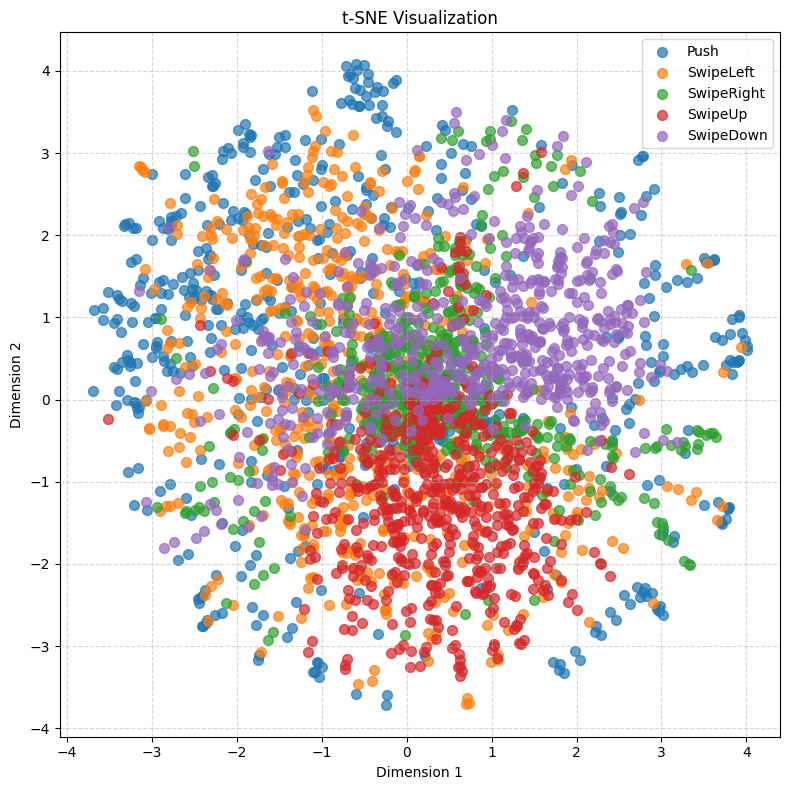

In [13]:
visualize_features(test_data.reshape(test_data.shape[0], -1), test_label, Cluster_list)

### Features plotting

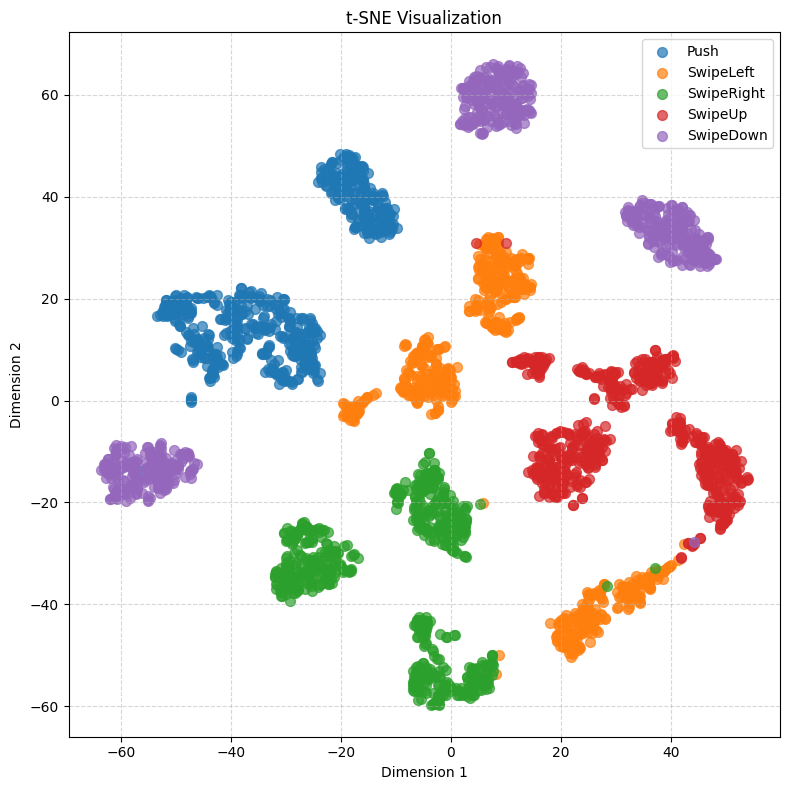

In [14]:
visualize_features(features, labels, Cluster_list)

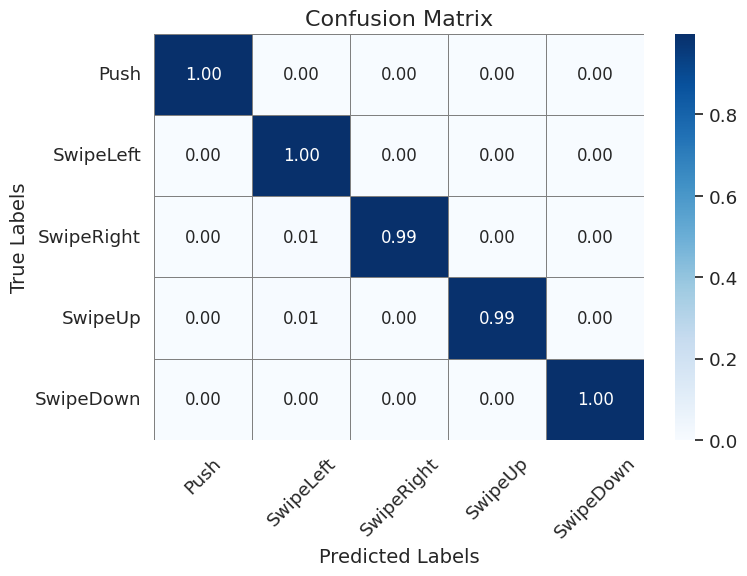

In [15]:
visualize_confusion_matrix(features, labels, Cluster_list)

In [25]:
class GestureClassifier(nn.Module):
    def __init__(self, embed_dim=256, num_classes=6):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(p=0.2), 
            nn.Linear(embed_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x):
        return self.classifier(x)

class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)  
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def create_data_loaders(features, labels, batch_size=64, val_ratio=0.2):
    set_seed(42)
    dataset = FeatureDataset(features, labels)
    train_size = int((1 - val_ratio) * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_set, batch_size=batch_size*2, shuffle=False, pin_memory=True)
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, epochs=20, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_model_path = 'best_model.pt'

    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0.0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), best_model_path)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss/len(train_loader):.4f} '
              f'Acc: {correct/len(train_loader.dataset):.4f} | '
              f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    model.load_state_dict(torch.load(best_model_path, weights_only=False))

def evaluate(model, dataloader, criterion, device):
    model.eval()
    loss, correct = 0.0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss += criterion(outputs, y).item()
            correct += (outputs.argmax(1) == y).sum().item()
    return loss/len(dataloader), correct/len(dataloader.dataset)


In [26]:
train_feature, test_feature, train_label, test_label = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=42)

print(f'The number of training samples is {train_feature.shape[0]}, '
      f'the number of test samples is {test_feature.shape[0]}')

model = GestureClassifier(embed_dim=256, num_classes=len(Cluster_list))
train_loader, val_loader = create_data_loaders(train_feature, train_label)
train_model(model, train_loader, val_loader, epochs=50, lr=1e-3)

test_loader = DataLoader(FeatureDataset(test_feature, test_label), batch_size=32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, acc = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
print(f"Test Accuracy: {acc:.4f}")

The number of training samples is 2400, the number of test samples is 600
Epoch 1/50: Train Loss: 4.7581 Acc: 0.2099 | Val Loss: 1.4400 Acc: 0.3583
Epoch 2/50: Train Loss: 3.0574 Acc: 0.2885 | Val Loss: 1.0498 Acc: 0.5521
Epoch 3/50: Train Loss: 2.2993 Acc: 0.3646 | Val Loss: 0.9016 Acc: 0.6813
Epoch 4/50: Train Loss: 1.7421 Acc: 0.4292 | Val Loss: 0.8383 Acc: 0.7271
Epoch 5/50: Train Loss: 1.5179 Acc: 0.4964 | Val Loss: 0.6468 Acc: 0.7979
Epoch 6/50: Train Loss: 1.2100 Acc: 0.5604 | Val Loss: 0.5075 Acc: 0.8896
Epoch 7/50: Train Loss: 1.0912 Acc: 0.5901 | Val Loss: 0.4383 Acc: 0.9167
Epoch 8/50: Train Loss: 0.8831 Acc: 0.6651 | Val Loss: 0.4017 Acc: 0.9187
Epoch 9/50: Train Loss: 0.8112 Acc: 0.7000 | Val Loss: 0.4839 Acc: 0.8208
Epoch 10/50: Train Loss: 0.7051 Acc: 0.7344 | Val Loss: 0.3952 Acc: 0.8667
Epoch 11/50: Train Loss: 0.6124 Acc: 0.7625 | Val Loss: 0.3165 Acc: 0.9187
Epoch 12/50: Train Loss: 0.5644 Acc: 0.7854 | Val Loss: 0.2807 Acc: 0.9208
Epoch 13/50: Train Loss: 0.5226 Acc